In [70]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine, utils
import torchinfo


In [57]:
#VGG16, GoogLenet, AlexNet, ResNeXt, efficientnet and DenseNet are the architectures

In [58]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [59]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [60]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [61]:
#HyperParameters
batch_Size = 3
learning_rate = 0.0001
epochS = 15
dropout_prob = 0.5

In [62]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [63]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x202e1b2ade0>,
 ['high', 'low', 'medium'])

In [64]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

In [65]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.features.parameters():
#     param.requires_grad = False

In [66]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [67]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [68]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  7%|▋         | 1/15 [00:20<04:47, 20.53s/it]

Epoch: 1 | train_loss: 1.0360 | train_acc: 0.5000 | test_loss: 0.9811 | test_acc: 0.5417


 13%|█▎        | 2/15 [00:40<04:20, 20.00s/it]

Epoch: 2 | train_loss: 0.9682 | train_acc: 0.5833 | test_loss: 0.9584 | test_acc: 0.4583


 20%|██        | 3/15 [00:59<03:58, 19.90s/it]

Epoch: 3 | train_loss: 0.8698 | train_acc: 0.6548 | test_loss: 0.9018 | test_acc: 0.5417


 27%|██▋       | 4/15 [01:20<03:43, 20.29s/it]

Epoch: 4 | train_loss: 0.7531 | train_acc: 0.7619 | test_loss: 0.8317 | test_acc: 0.6250


 33%|███▎      | 5/15 [01:41<03:24, 20.43s/it]

Epoch: 5 | train_loss: 0.7484 | train_acc: 0.7738 | test_loss: 0.7783 | test_acc: 0.6250


 40%|████      | 6/15 [02:03<03:09, 21.02s/it]

Epoch: 6 | train_loss: 0.6818 | train_acc: 0.7738 | test_loss: 1.0203 | test_acc: 0.5833


 47%|████▋     | 7/15 [02:27<02:56, 22.10s/it]

Epoch: 7 | train_loss: 0.6126 | train_acc: 0.7857 | test_loss: 0.7867 | test_acc: 0.5833


 53%|█████▎    | 8/15 [02:51<02:36, 22.40s/it]

Epoch: 8 | train_loss: 0.5161 | train_acc: 0.8333 | test_loss: 0.7529 | test_acc: 0.6250


 60%|██████    | 9/15 [03:13<02:14, 22.35s/it]

Epoch: 9 | train_loss: 0.4935 | train_acc: 0.8214 | test_loss: 0.7038 | test_acc: 0.7083


 67%|██████▋   | 10/15 [03:33<01:48, 21.63s/it]

Epoch: 10 | train_loss: 0.3314 | train_acc: 0.9524 | test_loss: 0.7295 | test_acc: 0.7083


 73%|███████▎  | 11/15 [03:53<01:24, 21.21s/it]

Epoch: 11 | train_loss: 0.4807 | train_acc: 0.7976 | test_loss: 0.5817 | test_acc: 0.7500


 80%|████████  | 12/15 [04:13<01:02, 20.93s/it]

Epoch: 12 | train_loss: 0.3401 | train_acc: 0.9167 | test_loss: 0.5709 | test_acc: 0.8333


 87%|████████▋ | 13/15 [04:33<00:41, 20.54s/it]

Epoch: 13 | train_loss: 0.2148 | train_acc: 0.9524 | test_loss: 0.7864 | test_acc: 0.7083


 93%|█████████▎| 14/15 [04:52<00:20, 20.23s/it]

Epoch: 14 | train_loss: 0.4395 | train_acc: 0.8452 | test_loss: 0.5536 | test_acc: 0.7917


100%|██████████| 15/15 [05:13<00:00, 20.89s/it]

Epoch: 15 | train_loss: 0.2207 | train_acc: 0.9524 | test_loss: 0.5665 | test_acc: 0.8333
[INFO] Total training time: 313.422 seconds


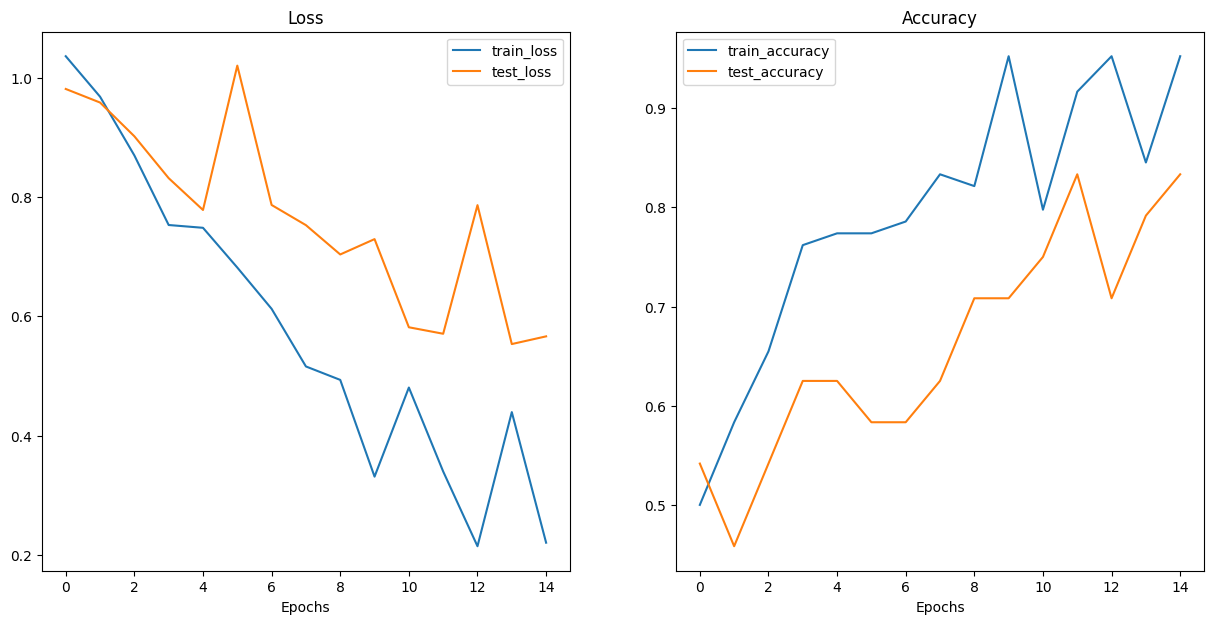

In [69]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

In [71]:
utils.save_model(model=model,
                 target_dir="models",
                 model_name="efficientNet1.pth")

[INFO] Saving model to: models\efficientNet1.pth
